Visualize embeddings of model with tSNE plots

In [103]:
from libauc.losses import AUCMLoss, AUCM_MDCALoss, CrossEntropyLoss, SupConLoss
from libauc.optimizers import PESG
from libauc.models import resnet20 as ResNet20
from libauc.datasets import CIFAR10
from libauc.utils import ImbalancedDataGenerator
from libauc.sampler import DualSampler
from calibration_library.metrics import ECELoss, SCELoss
import torch
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from sklearn.metrics import roc_auc_score
import sys

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


In [104]:
class ImageDataset(Dataset):
    def __init__(self, images, targets, image_size=32, crop_size=30, mode='train'):
        self.images = images.astype(np.uint8)
        self.targets = targets
        self.mode = mode
        self.transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomCrop((crop_size, crop_size), padding=None),
            transforms.RandomHorizontalFlip(),
            transforms.Resize((image_size, image_size)),
        ])
        self.transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((image_size, image_size)),
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]
        image = Image.fromarray(image.astype('uint8'))
        if self.mode == 'train':
            image = self.transform_train(image)
        else:
            image = self.transform_test(image)
        return image, target



In [105]:
# paramaters
SEED = 123
BATCH_SIZE = 128
imratio = 0.01  # for demo
lr = 0.1
weight_decay = 1e-4

In [106]:
test_data, test_targets = CIFAR10(
    root='../../MDCA-Calibration-main/data', train=False)
print("data found")
generator = ImbalancedDataGenerator(verbose=True, random_seed=SEED)
(test_images, test_labels) = generator.transform(
    test_data, test_targets, imratio=0.5)
testloader = torch.utils.data.DataLoader(ImageDataset(
    test_images, test_labels, mode='test'), batch_size=BATCH_SIZE, shuffle=False, num_workers=1,  pin_memory=True)




Files already downloaded and verified
data found
#SAMPLES: [10000], POS:NEG: [5000 : 5000], POS RATIO: 0.5000


In [107]:
pretrained_model = 'cifarmdca.pth'
model = ResNet20()
model = model.cuda()
model.load_state_dict(torch.load(pretrained_model))
model.eval()


ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [108]:
out = None
# Define a hook function. It sets the global out variable equal to the
# output of the layer to which this hook is attached to.
def hook(module, input, output):
    global out
    out = output
    return None
# Your model layer has a register_forward_hook that does the registering for you
# model.register_forward_hook(hook)
# model.register_forward_hook()
# model.linear.register_forward_hook(hook)
model.layer3.register_forward_hook(hook)
# Then you just loop through your dataloader to extract the embeddings
embeddings = None
labels = np.zeros(shape=(0))
for x,y in iter(testloader):
    global out
    x = x.cuda()
    model(x)
    labels = np.concatenate((labels,y.numpy().ravel()))
    if embeddings is None:
        embeddings = out.cpu().detach().numpy()
    else:
        embeddings = np.concatenate([embeddings, out.detach().cpu().numpy()],axis=0)


In [109]:
# convert to 2D
embeddings_2d = embeddings.reshape(embeddings.shape[0], -1)
embeddings_2d.shape

(10000, 4096)

/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


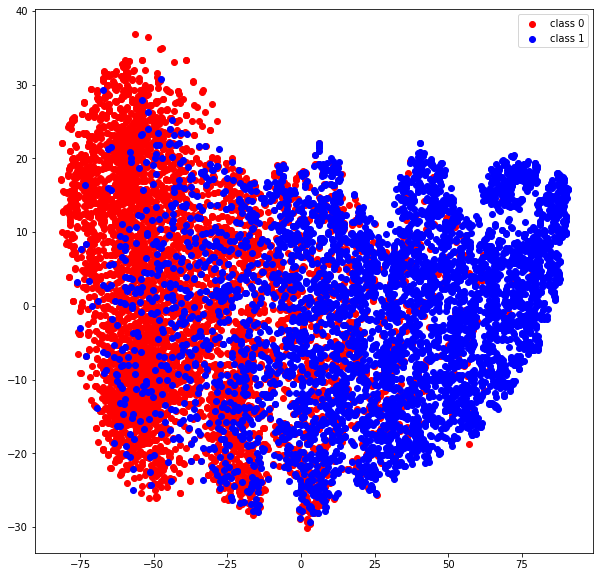

In [110]:

tsne = TSNE(n_components=2, init='pca', random_state=0, learning_rate='auto')
X_tsne = tsne.fit_transform(embeddings_2d)
# visualize 2d scatter plot
plt.figure(figsize=(10, 10))
# color red for class 0, blue for class 1
plt.scatter(X_tsne[labels==0, 0], X_tsne[labels==0, 1], c='r', label='class 0')
plt.scatter(X_tsne[labels==1, 0], X_tsne[labels==1, 1], c='b', label='class 1')
plt.legend()
plt.show()


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(10000, 2)


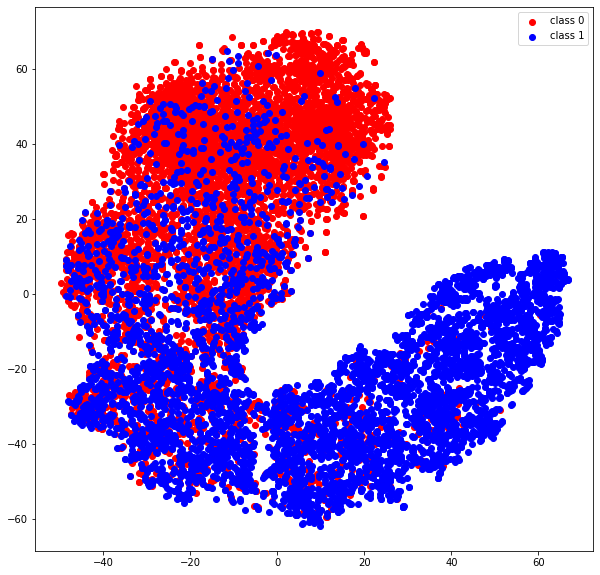

In [111]:

tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(embeddings_2d)
print(X_tsne.shape)
# visualize 2d scatter plot
plt.figure(figsize=(10, 10))
# color red for class 0, blue for class 1
plt.scatter(X_tsne[labels==0, 0], X_tsne[labels==0, 1], c='r', label='class 0')
plt.scatter(X_tsne[labels==1, 0], X_tsne[labels==1, 1], c='b', label='class 1')
plt.legend()
plt.show()